In [1]:
# In order to have a reference line, a base model will be trained with face cropped and aligned for bonafide vs printed vs screen classes (3 classes).
# - obj: train over FLICKR and eval with FLICKR

# take json files and gather data to training format -> bonafide vs imposter

In [2]:
import os
import json
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.paths import list_images
from sklearn.model_selection import train_test_split
from augmentations import avg_aug

from tensorflow.keras.metrics import FalsePositives, FalseNegatives, AUC

%load_ext autoreload
%autoreload 2

In [3]:
datapath = '../data/02_intermediate/flickr'
images_list = [*list_images(datapath)]
_classes = ('attack', 'bonafide')
_bf_index = _classes.index('bonafide')

In [4]:
epochs = 50
batch_size = 16
buffer_size = 8
_size = (224, 224)
learning_rate = 1e-4
loss = 'categorical_crossentropy'


bf, att = [], []

for imdir in images_list:
    if _classes[_bf_index] in imdir.split(os.sep): # if 'bonafide' in imdir
        bf.append(imdir)
    else:
        att.append(imdir)

In [5]:
len(bf), len(att)

(3000, 10975)

In [6]:
bf[0]

'../data/02_intermediate/flickr/bonafide/originales_ronda3y4/F12272.png'

In [7]:
def _parse_function_with_DA(impath):
    # instantiate augmentation here to overcome "not-changing-random-seed" bug
    # this could lead to an speed decrease or an overheap, dont know
    aug = avg_aug() # think about deleting aug after use
    
    # image reading
    image = tf.io.read_file(impath)
    image = tf.io.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, _size)
    image = tf.cast(image, tf.uint8)
    image = tf.numpy_function(func=aug.augment_image, inp=[image], Tout=tf.uint8)
    image = tf.cast(image, tf.float32)
    image = image / 255.
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[4]
    # 4th element is the class id
    if _cls == 'bonafide':
        lb = tf.cast([0, 1], tf.float32)
    else:
        lb = tf.cast([1, 0], tf.float32)
    
    return image, lb

def _parse_function_without_DA(impath):
    # image reading
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, _size)
    image = image / 255.
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[4]
    # 4th element is the class id
    if _cls == 'bonafide':
        lb = tf.cast([0, 1], tf.float32)
    else:
        lb = tf.cast([1, 0], tf.float32)
    
    return image, lb

# How to make dataset

In [8]:
# def train, test, val sets # done

In [9]:
bf_y = np.ones(len(bf))
att_y = np.zeros(len(att))

In [10]:
bf_y.shape, att_y.shape

((3000,), (10975,))

In [11]:
X = np.concatenate([bf, att])
y = np.concatenate([bf_y, att_y])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
np.unique(X_train, return_counts=True), np.unique(X_val, return_counts=True), np.unique(X_test, return_counts=True)

# Train data

In [14]:
train_dataset = tf.cast(X_train, dtype=tf.string)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.map(_parse_function_with_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(batch_size)

2022-10-29 01:38:25.768263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 01:38:25.768690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 01:38:25.793355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 01:38:25.793775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 01:38:25.794439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

# Val data

In [15]:
val_dataset = tf.cast(X_val, dtype=tf.string)
val_dataset = tf.data.Dataset.from_tensor_slices(val_dataset)
# val_dataset = val_dataset.shuffle(buffer_size)
val_dataset = val_dataset.map(_parse_function_without_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(1)

# Test data

In [16]:
# test_dataset = tf.cast(X_test, dtype=tf.string)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
# test_dataset = val_dataset.shuffle(batch_size)
# test_dataset = val_dataset.map(_parse_function)
# test_dataset = val_dataset.cache()
# test_dataset = val_dataset.batch(1)

In [17]:
len(train_dataset)

525

In [18]:
# for e in range(3):
    
#     i = 0
    
#     for im, lb in iter(train_dataset):
#         if i < 3:
#             _class_argmax = np.argmax(lb[0], axis=-1)
#             plt.title(f'GT label: {_classes[_class_argmax]}')
#             plt.imshow(im[0])
#             plt.show()
#         i += 1
#         # break

  0%|                                                                                                                                                                                        | 0/5 [00:00<?, ?it/s]/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name fo

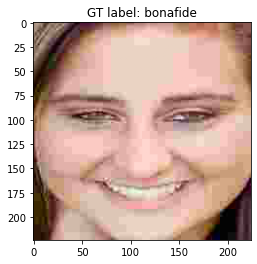

 20%|███████████████████████████████████▏                                                                                                                                            | 1/5 [00:02<00:08,  2.11s/it]

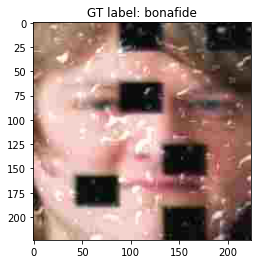

 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 2/5 [00:02<00:03,  1.16s/it]/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name fo

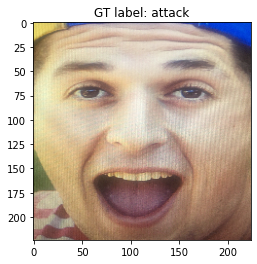

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 3/5 [00:03<00:02,  1.12s/it]/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name fo

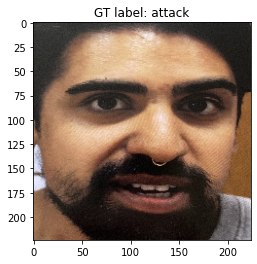

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4/5 [00:04<00:00,  1.03it/s]/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name fo

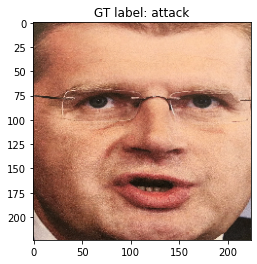

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17it/s]2022-10-29 01:38:32.323460: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
100%|█████████████████████████████████████████████████████

In [19]:
with warnings.catch_warnings():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.simplefilter("ignore")
    
    for bs in tqdm(train_dataset.take(5)):
        im, lb = bs

        _class_argmax = np.argmax(lb[0], axis=-1)
        plt.title(f'GT label: {_classes[_class_argmax]}')
        plt.imshow(im[0])
        plt.show()
        # break

In [20]:
# def model to be trained
# def a sequence of variables to be explored

In [21]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [22]:
input_shape = (*_size, 3) # 224x224x3

model = MobileNetV2(input_shape=input_shape, alpha=1.0, include_top=False, weights=None, pooling='max')

In [23]:
x = model.output
# Added by the 'pooling' argument
# x = GlobalAveragePooling2D()(x)
x = Dense(units=2, activation="softmax", use_bias=True, name="Logits")(x)

model = Model(inputs=model.input, outputs=x)

In [24]:
# model.summary()

In [25]:
# compile model

# optimizer = Adam(learning_rate=learning_rate, amsgrad=True, decay=1e-6)
optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True, decay=1e-6)

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=['acc', FalsePositives(), FalseNegatives(), AUC(curve='PR')], 
)

In [ ]:
with warnings.catch_warnings():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.simplefilter("ignore")
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=epochs, max_queue_size=36, 
        use_multiprocessing=True, workers=8
    )

Epoch 1/50


/tmp/ipykernel_27841/336000024.py:4: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)
2022-10-29 01:38:37.446756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-10-29 01:38:37.889484: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-29 01:38:37.890504: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


525/525 [==============================] - 847s 2s/step - loss: 0.6687 - acc: 0.7417 - false_positives: 2166.0000 - false_negatives: 2166.0000 - auc: 0.7348 - val_loss: 0.6610 - val_acc: 0.7839 - val_false_positives: 604.0000 - val_false_negatives: 604.0000 - val_auc: 0.7462
Epoch 2/50
525/525 [==============================] - 45s 85ms/step - loss: 0.5965 - acc: 0.7517 - false_positives: 2082.0000 - false_negatives: 2082.0000 - auc: 0.7562 - val_loss: 0.6294 - val_acc: 0.7839 - val_false_positives: 604.0000 - val_false_negatives: 604.0000 - val_auc: 0.7462
Epoch 3/50
525/525 [==============================] - 46s 87ms/step - loss: 0.5886 - acc: 0.7537 - false_positives: 2065.0000 - false_negatives: 2065.0000 - auc: 0.7623 - val_loss: 0.5942 - val_acc: 0.7839 - val_false_positives: 604.0000 - val_false_negatives: 604.0000 - val_auc: 0.7462
Epoch 4/50
525/525 [==============================] - 45s 85ms/step - loss: 0.5652 - acc: 0.7586 - false_positives: 2024.0000 - false_negatives: 202

In [ ]:
# define a plot function to plot history scores
def plot_history(history, title, save_path, figsize=(12, 6), font_scale=1, linewidth=3.5):
    with sns.plotting_context(
        "notebook", font_scale=2, rc={"lines.linewidth": linewidth}
    ):
        epochs = len(history.history["val_loss"])
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(title)
        ax.set_ylabel("Loss/Acc.")
        ax.set_xlabel("Epochs")
        sns.lineplot(
            history.history["loss"], label="Train Loss", ax=ax, linestyle='--',
        )
        sns.lineplot(
            history.history["val_loss"], label="Val. Loss", ax=ax, linestyle='--',
        )
        sns.lineplot(
            history.history["acc"], label="Train Acc.", ax=ax, linestyle='--',
        )
        sns.lineplot(
            history.history["val_acc"], label="Val. Acc.", ax=ax, linestyle='--',
        )
        fig.savefig(save_path)


# call plot function
plot_history(history, "model Training Loss & Acc.", "train_plot.png")

In [ ]:
# apply sklearn labelencoder


In [ ]:
model.evaluate(val_dataset)